In [1]:
import lalsimulation as ls
import lal
import numpy as np

import matplotlib.pyplot as plt

import math
import time
from scipy.optimize import minimize


In [12]:
import matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})


In [3]:
def compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant):
    
    # These have to be set to 0 by definition
    inc, phiC  = 0., 0.
    
    # Generate the modes hlm 
    hlms = ls.SimInspiralChooseFDModes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, f_low, phiC, distance, inc, None, approximant)
    
    return hlms    

# Get the 2 waveforms

In [4]:
M = 80.*lal.MSUN_SI
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 78403.869284*1e6*lal.PC_SI
fRef_in = f_low
q = 1.01
chi1_z = 0.
chi2_z = 0.
m1, m2 = q*M/(1.+q), M/(1.+q)

freq_range = np.linspace(0, f_max, int(f_max/deltaF))

In [5]:
m2 / lal.MSUN_SI

39.800995024875625

# New Implementation

In [6]:
approximant = ls.IMRPhenomXAS
hplus , hcross  = ls.SimInspiralChooseFDWaveform(m1=m1, m2=m2, S1x=chi1_x, S1y=chi1_y, S1z=chi1_z, S2x=chi2_x, S2y=chi2_y, S2z=chi2_z, distance=distance, inclination=iota, phiRef=phiRef, longAscNodes=0., eccentricity=0., meanPerAno=0., deltaF=deltaF, f_min=f_low, f_max=f_max, f_ref=fRef_in, LALpars=None, approximant=approximant)
hlm_1 = hplus.data.data[:-1] + 1.j*hcross.data.data[:-1]
# hlm_1 = -hlm_1 # Flipped to try and fix convention issues

In [7]:
print(len(hplus.data.data))

65537


In [8]:
approximant = ls.IMRPhenomD
hplus , hcross  = ls.SimInspiralChooseFDWaveform(m1=m1, m2=m2, S1x=chi1_x, S1y=chi1_y, S1z=chi1_z, S2x=chi2_x, S2y=chi2_y, S2z=chi2_z, distance=distance, inclination=iota, phiRef=phiRef, longAscNodes=0., eccentricity=0., meanPerAno=0., deltaF=deltaF, f_min=f_low, f_max=f_max, f_ref=fRef_in, LALpars=None, approximant=approximant)
hlm_2 = hplus.data.data[:-1] + 1.j*hcross.data.data[:-1]
hlm_2 = -hlm_2 # Flipped to try and fix convention issues

## (Old Implementation)

In [9]:
# # IMRPhenomXAS
# hlm_1_LAL = ls.SimIMRPhenomXASGenerateFD(m1, m2, chi1_x, chi2_x, distance, f_low, f_max, deltaF, phi_c, fRef_in, None)
# hlm_1 = hlm_1_LAL.data.data[:-1]


In [10]:
# # IMRPhenomD
# hlm_2_LAL = ls.SimIMRPhenomDGenerateFD(phi_c, fRef_in,deltaF, m1, m2, chi1_x, chi2_x, f_low, f_max, distance, None, ls.NRTidal_V)
# hlm_2 = hlm_2_LAL.data.data[:-1]


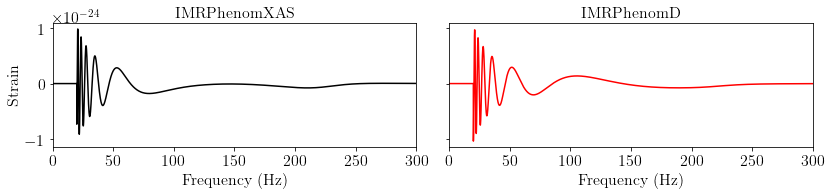

In [20]:
f, (ax1, ax2)= plt.subplots(nrows=1, ncols=2,  sharey=True, figsize=(12,3)) 
ax1.plot(freq_range, np.real(hlm_1), color='k')
ax1.set_xlim(0, 300)
ax1.set_title('IMRPhenomXAS', fontsize=16)
ax1.set_ylabel("Strain")
ax1.set_xlabel("Frequency (Hz)")

ax2.plot(freq_range, np.real(hlm_2), color='r')
ax2.set_xlim(0, 300)
ax2.set_title('IMRPhenomD', fontsize=16)
# ax2.set_ylabel("Strain")
ax2.set_xlabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

# Decomposition

We want to decompose the waveforms into the following form:
$$ h_{lm} = A_{lm} \exp[{i \phi_{lm}}]$$.

In [10]:
a1 = np.abs(hlm_1)
phi1 = np.unwrap(np.angle(hlm_1))

In [11]:
a2 = np.abs(hlm_2)
phi2 = np.unwrap(np.angle(hlm_2))

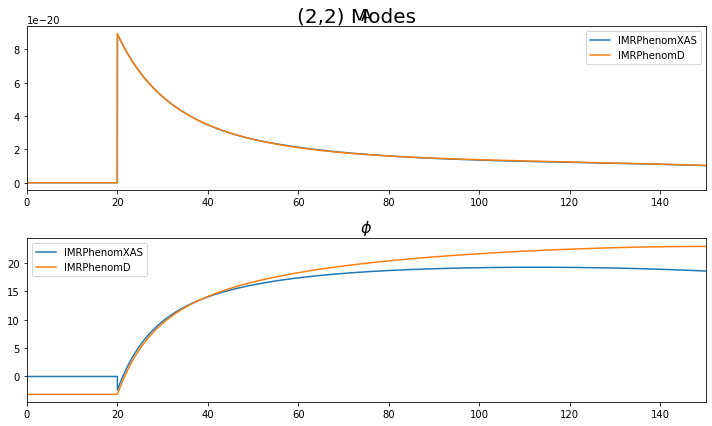

In [12]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,6)) 

ax1.plot(freq_range, a1, label='IMRPhenomXAS')
ax1.plot(freq_range, a2, label='IMRPhenomD')
ax1.set_xlim(0,150)
ax1.set_title('A', fontsize=16)

ax1.legend()

ax2.plot(freq_range, phi1, label='IMRPhenomXAS')
ax2.plot(freq_range, phi2, label='IMRPhenomD')
ax2.set_xlim(0,150)
ax2.set_title('$\phi$', fontsize=16)
ax2.legend()

plt.suptitle('(2,2) Modes', fontsize=20)

plt.tight_layout()
plt.show()

# Create Hybrid Waveform

For any two given waveforms with the following decompositions:
$$ h^{(1)}_{lm} = A^{(1)}_{lm} \exp[{i \phi^{(1)}_{lm}}]$$
$$ h^{(2)}_{lm} = A^{(2)}_{lm} \exp[{i \phi^{(2)}_{lm}}]$$

We can construct a hybrid waveform:
$$ h^{(hyb)}_{lm} = A^{(hyb)}_{lm} \exp[{i \phi^{(hyb)}_{lm}}]$$

where
$$ A^{(hyb)}_{lm} = A^{(1)}_{lm}\cdot (1-\lambda) +  A^{(2)}_{lm}\cdot \lambda , \\
\phi^{(hyb)}_{lm} = \phi^{(1)}_{lm}\cdot (1-\lambda) +  \phi^{(2)}_{lm}\cdot \lambda $$

In [13]:
def get_hyb(a1, a2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
    return a1*(1-lam) + a2*(lam)

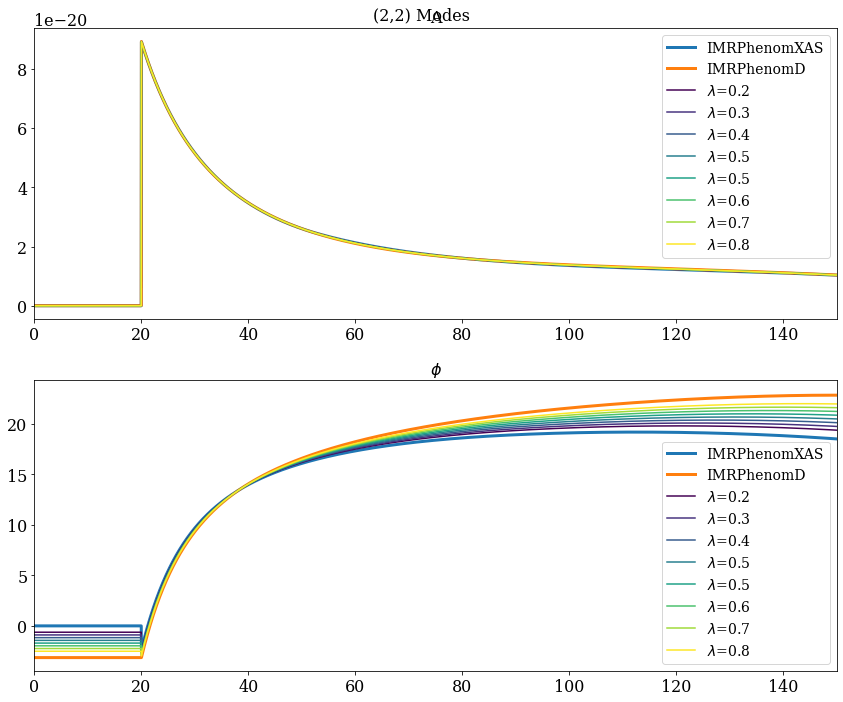

In [39]:
lams = np.linspace(0.2, 0.8, 8)
colors = plt.cm.viridis(np.linspace(0, 1, 8))

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(12,10)) 

lw = 3

ax1.plot(freq_range, a1, lw=lw, label='IMRPhenomXAS')
ax1.plot(freq_range, a2, lw=lw, label='IMRPhenomD')

for i in range(len(lams)):
    a_hyb = get_hyb(a1, a2, lams[i])
    ax1.plot(freq_range, a_hyb, color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    
ax1.set_xlim(0,150)
ax1.set_title('A', fontsize=16)
ax1.legend(fontsize=14)


ax2.plot(freq_range, phi1, lw=lw, label='IMRPhenomXAS')
ax2.plot(freq_range, phi2, lw=lw, label='IMRPhenomD')

for i in range(len(lams)):
    phi_hyb = get_hyb(phi1, phi2, lams[i])
    ax2.plot(freq_range, phi_hyb, color=colors[i], label=f'$\lambda$={lams[i]:.1f}')

ax2.set_xlim(0,150)
ax2.set_title('$\phi$', fontsize=16)

ax2.legend(fontsize=14, loc='lower right')

plt.suptitle('(2,2) Modes', fontsize=16)


plt.tight_layout()
plt.show()

# Reconstruct Hybrid Waveform

In [15]:
def get_h_hyb(a1, a2, phi1, phi2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    return a_hyb * np.exp(1.j * phi_hyb)

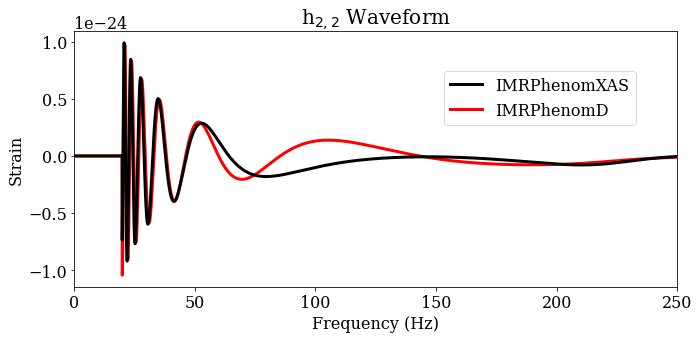

In [28]:
f, (ax)= plt.subplots(1, 1,  figsize=(10,5)) 

lams = np.linspace(0.2, 0.8, 4)
colors = plt.cm.viridis(lams)

lw=3

ax.plot(freq_range, np.real(hlm_1), lw=lw, c='k', label='IMRPhenomXAS', zorder=10)

# for i in range(len(lams)):
#     h_hyb = get_h_hyb(a1, a2, phi1, phi2, lams[i])
#     ax.plot(freq_range, h_hyb, color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    
ax.plot(freq_range, np.real(hlm_2), lw=lw, c='r', label='IMRPhenomD', zorder=9)


ax.set_xlim(0,250)
# ax.set_xlim(48, 50)
ax.set_title('h$_{2,2}$ Waveform', fontsize=20)

plt.legend(fontsize=16, bbox_to_anchor=(0.6, 0.6))

plt.ylabel('Strain', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.tight_layout()
# plt.savefig('hybrid_waveform_demo.pdf')
plt.show()

[4 3 2 1]


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


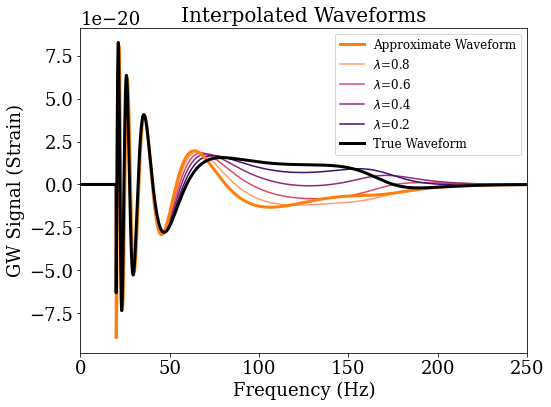

In [77]:
import matplotlib
font = {'family' : 'serif',
        'size'   : 18}
matplotlib.rc('font', **font)

f, (ax)= plt.subplots(1, 1,  figsize=(8,6)) 

lams = np.linspace(0., 1., 6)
colors = plt.cm.magma(lams)
indices = np.linspace(1, 4, 4, dtype=int)
indices = indices[::-1]

print(indices)
lw=3

ax.plot(freq_range, np.real(hlm_2), lw=lw, c='C1', label='Approximate Waveform', zorder=9)

for i in indices:
    h_hyb = get_h_hyb(a1, a2, phi1, phi2, lams[i])
    ax.plot(freq_range, h_hyb, color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    

ax.plot(freq_range, np.real(hlm_1), lw=lw, c='k', label='True Waveform', zorder=10)



ax.set_xlim(0,250)
# ax.set_xlim(48, 50)
ax.set_title('Interpolated Waveforms', fontsize=20)

plt.legend(fontsize=12, loc='upper right')

plt.ylabel('GW Signal (Strain)', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.tight_layout()
plt.show()

# Faithfulness

In [57]:
def match_HM_k_opt_LAL(hlm1_FD,hlm2_FD,iota,phi,kappa,deltaF, Sn, zpfact=2):
    # Check if the two waveform have the same size
    assert(len(hlm1_FD.fdata.data) == len(hlm1_FD.fdata.data))

    wf1_FD = compute_hFDNR_LAL(hlm1_FD,iota, phi, kappa)[:-1]

    # Compute the norm of the true waveform
    norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

    # Define the match as a function of phi. This match is analytically optimized over kappa
    def match_HM_phi_kopt(x):
        try:
            # Unpacking for multiD mimimization
            len(x)
            x = x[0]
        except:
            pass
        
        hp_ROM, hc_ROM = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm2_FD,iota,x)
        hp_ROM, hc_ROM = hp_ROM.data.data[:-1], hc_ROM.data.data[:-1]
        n = len(hp_ROM)
        A_p = np.sqrt(np.sum(np.abs(hp_ROM)**2/Sn))
        A_c = np.sqrt(np.sum(np.abs(hc_ROM)**2/Sn))

        if A_c/A_p>1e-8: #if we really have two non zero polarizations
            Ipc = np.real(np.dot(np.conjugate(hp_ROM),hc_ROM/Sn))
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
            integrand = np.conjugate(hc_ROM)*wf1_FD/Sn
            rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

            alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
            kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

            gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
            sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
            beta = (A_p**2+A_c**2)/2.

            #print A_p,A_c,Ipc,gamma,sigma0,beta
            num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
            den = norm1*np.sqrt(beta**2-gamma**2)
            overlap = num/den
        else:
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
            maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
            overlap = maxifftterm/(norm1*A_p)

        return -overlap

    # Numerically optimize over phi
    # First find the minimum in a discrete manner
    phi_ini_guess = np.linspace(0.,2*np.pi,num=40)
    discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
    discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
    res =minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
    return -match_HM_phi_kopt(res.x)


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


## Create Dummy Waveform to perform analysis on

In [5]:
theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

In [6]:
M = 50.*lal.MSUN_SI
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 1e6*lal.PC_SI
fRef_in = f_low
q = 3.1
chi1_z = 0.
chi2_z = 0.
m1, m2 = q*M/(1.+q), M/(1.+q)

freq_range = np.linspace(0, f_max, int(f_max/deltaF))

kappa = -1j* np.log((Fplus + 1j*Fcross) / (np.sqrt(Fplus**2 + Fcross**2)))

hlm_dummy_xas = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

hlm_dummy_d = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

type(hlm_dummy_d)

lalsimulation.SphHarmFrequencySeries

In [7]:
freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]
print(zero_pos)

65536


In [8]:
# IMRPhenomXAS
# hlm_1_LAL = ls.SimIMRPhenomXASGenerateFD(m1, m2, chi1_x, chi2_x, distance, f_low, f_max, deltaF, phi_c, fRef_in, None)

hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant = ls.IMRPhenomXAS)
hlm_1_LAL = hplus.data.data + 1j*hcross.data.data 

# set dummy (2,2) data to IMRPhenomD waveform
l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m
print(f"overwriting ({l}, {m}) mode")

freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

hlm_xas_extended = np.zeros(freq_size, dtype=complex)
# hlm_xas_extended[:zero_pos+1] = hlm_1_LAL[::-1]
hlm_xas_extended[:zero_pos+1] = 0

hlm_xas_extended[zero_pos:] = hlm_1_LAL

hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended


overwriting (2, 2) mode


In [9]:
# IMRPhenomD
# hlm_2_LAL = ls.SimIMRPhenomDGenerateFD(phi_c, fRef_in,deltaF, m1, m2, chi1_x, chi2_x, f_low, f_max, distance, None, ls.NRTidal_V)

hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=ls.IMRPhenomD)
hlm_2_LAL = hplus.data.data + 1j*hcross.data.data
hlm_2_LAL = -hlm_2_LAL # flipped to fix convention

# set dummy (2,2) data to IMRPhenomXAS waveform
l = hlm_dummy_d.next.next.next.next.next.next.next.next.l
m = hlm_dummy_d.next.next.next.next.next.next.next.next.m
print(f"overwriting ({l}, {m}) mode")

freq_size = len(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data)
zero_pos = np.where(hlm_dummy_d.fdata.data==0)[0][0]

hlm_d_extended = np.zeros(freq_size, dtype=complex)
# hlm_d_extended[:zero_pos+1] = hlm_2_LAL[::-1]
hlm_d_extended[:zero_pos+1] = 0
hlm_d_extended[zero_pos:] = hlm_2_LAL

hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data = hlm_d_extended


overwriting (2, 2) mode


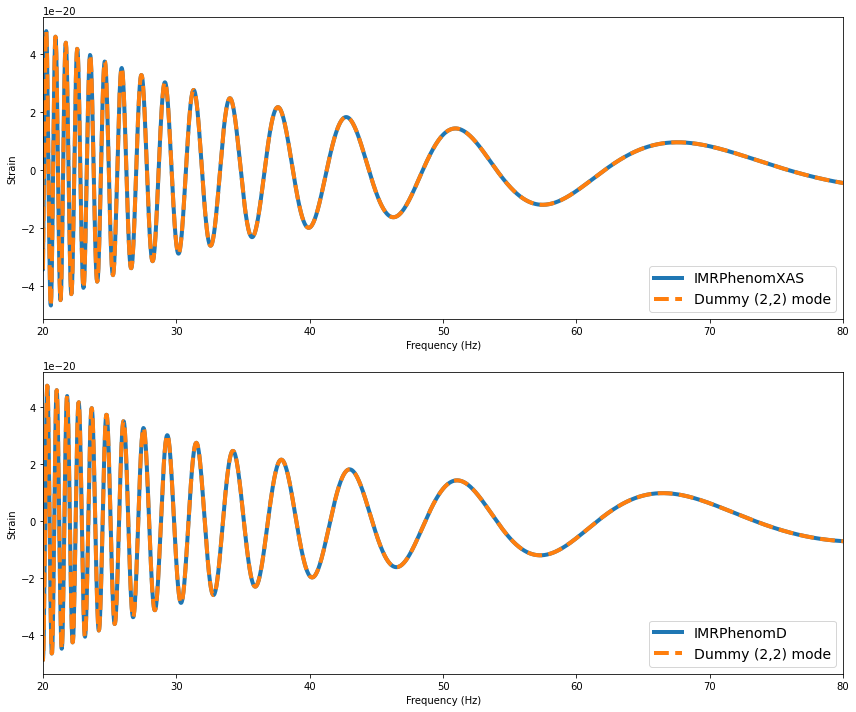

In [10]:
# confirm that the (2,2) modes have been overwritten correctly

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(12,10)) 

lw=4

ax1.plot(hlm_dummy_xas.fdata.data, np.real(hlm_xas_extended), lw=lw, label="IMRPhenomXAS")
ax1.plot(hlm_dummy_xas.fdata.data, np.real(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data),  lw=lw, linestyle='--', label="Dummy (2,2) mode")

ax1.set_xlim(20, 80)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel('Strain')
ax1.set_xlabel('Frequency (Hz)')

ax2.plot(hlm_dummy_d.fdata.data, np.real(hlm_d_extended), lw=lw, label="IMRPhenomD")
ax2.plot(hlm_dummy_d.fdata.data, np.real(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data),  lw=lw, linestyle='--', label="Dummy (2,2) mode")

ax2.set_xlim(20, 80)
ax2.legend(fontsize=14, loc='lower right')
ax2.set_ylabel('Strain')
ax2.set_xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

## Construct Hybrid Dummy Waveforms

In [11]:
def get_hyb_dummy(hlm_dummy, hlm_1, hlm_2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
        
    a1 = np.abs(hlm_1)
    phi1 = np.unwrap(np.angle(hlm_1))   
    
    a2 = np.abs(hlm_2)
    phi2 = np.unwrap(np.angle(hlm_2))

    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    hlm_hyb =  a_hyb * np.exp(1.j * phi_hyb)
    
    # set dummy (2,2) data to Hybrid waveform
    freq_size = len(hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy.fdata.data==0)[0][0]

    # Make sure the data extends to both sides of frequency space
    hlm_hyb_extended = np.zeros(freq_size, dtype=complex)
    # hlm_hyb_extended[:zero_pos+1] = hlm_hyb[::-1]
    hlm_hyb_extended[:zero_pos+1] = 0

    hlm_hyb_extended[zero_pos:] = hlm_hyb

    hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data = hlm_hyb_extended
    
    return hlm_dummy

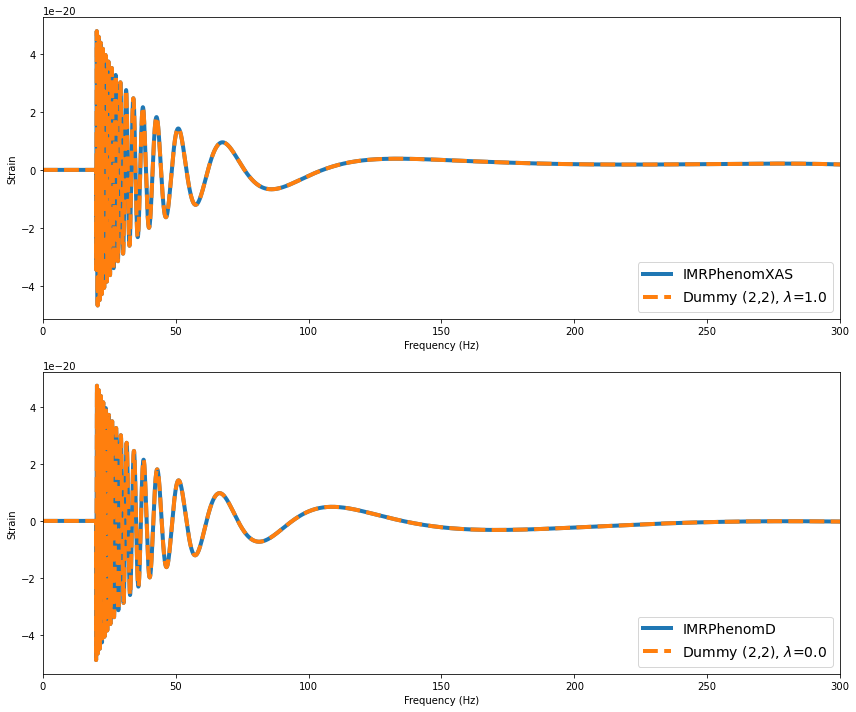

In [25]:
# confirm that the (2,2) modes have been overwritten correctly

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(12,10)) 
lw=4
hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
hlm_dummy_xas = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, 0.0);

ax1.plot(hlm_dummy_xas.fdata.data, np.real(hlm_xas_extended), lw=lw, label="IMRPhenomXAS")
ax1.plot(hlm_dummy_xas.fdata.data, np.real(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data),  lw=lw, linestyle='--', label="Dummy (2,2), $\lambda$=1.0")

ax1.set_xlim(0, 300)
ax1.legend(fontsize=14, loc='lower right')
ax1.set_ylabel('Strain')
ax1.set_xlabel('Frequency (Hz)')

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
hlm_dummy_d = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, 1.0);

ax2.plot(hlm_dummy_d.fdata.data, np.real(hlm_d_extended), lw=lw, label="IMRPhenomD")
ax2.plot(hlm_dummy_d.fdata.data, np.real(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data),  lw=lw, linestyle='--', label="Dummy (2,2), $\lambda$=0.0")

ax2.set_xlim(0, 300)
ax2.legend(fontsize=14, loc='lower right')
ax2.set_ylabel('Strain')
ax2.set_xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show();

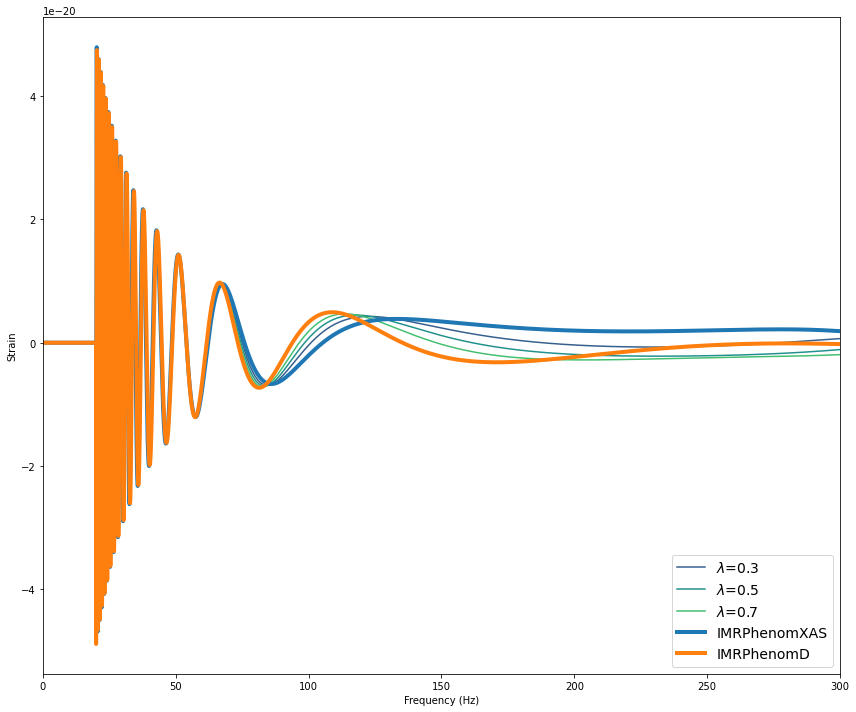

In [13]:
# confirm that the (2,2) modes have been overwritten correctly

f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
lw=4


lams = np.linspace(0.3, 0.7, 3)
colors = plt.cm.viridis(lams)


for i in range(len(lams)):
    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
    hlm_dummy_hybrid = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, lams[i]);
    ax.plot(hlm_dummy_hybrid.fdata.data, np.real(hlm_dummy_hybrid.next.next.next.next.next.next.next.next.mode.data.data), color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    

ax.plot(hlm_dummy_hybrid.fdata.data, np.real(hlm_xas_extended), lw=lw, label="IMRPhenomXAS")

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
hlm_dummy_d = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, 1.0);

ax.plot(hlm_dummy_d.fdata.data, np.real(hlm_d_extended), lw=lw, label="IMRPhenomD")
ax.set_xlim(0, 300)
ax.legend(fontsize=14, loc='lower right')
ax.set_ylabel('Strain')
ax.set_xlabel('Frequency (Hz)')

# plt.xlim(46, 50)
plt.tight_layout()
plt.show();

## Compute Faithfulness to IMRPhenomD for a single value of Lambda

In [14]:
def get_LIGO_psd(f_low,deltaF,len_wf):

    # Define the frequency series where to put the PSD
    epoch = lal.LIGOTimeGPS(0, 0)

    Sn = lal.CreateREAL8FrequencySeries("psd",epoch,0.,deltaF,lal.StrainUnit,len_wf)

    # Compute the PSD from the given f_low
    ls.SimNoisePSDaLIGOZeroDetHighPowerGWINC(Sn,f_low)
    
    Sn.data.data[0 : int(f_low/deltaF)] = Sn.data.data[int(f_low/deltaF)]
    Sn.data.data[-1] = Sn.data.data[-2]
    
    return Sn

In [15]:
def compute_hFDNR_LAL(hlm_FD,theta,phi,kappa):
    hpFD,hcFD = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm_FD,theta,np.pi/2.-phi)
    return np.cos(kappa)*hpFD.data.data+np.sin(kappa)*hcFD.data.data

In [16]:
Sn = get_LIGO_psd(f_low,deltaF,int(f_max/deltaF))

In [17]:
# IMRPhenomXAS
# hlm_xas = ls.SimIMRPhenomXASGenerateFD(m1, m2, chi1_x, chi2_x, distance, f_low, f_max, deltaF, phi_c, fRef_in, None)approximant = ls.IMRPhenomD
approximant = ls.IMRPhenomXAS
hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
hlm_xas = hplus.data.data + 1j*hcross.data.data

# IMRPhenomD
# hlm_d = ls.SimIMRPhenomDGenerateFD(phi_c, fRef_in,deltaF, m1, m2, chi1_x, chi2_x, f_low, f_max, distance, None, ls.NRTidal_V)
approximant = ls.IMRPhenomD
hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
hlm_d = hplus.data.data + 1j*hcross.data.data
hlm_d = -hlm_d # Flipped to account for convention


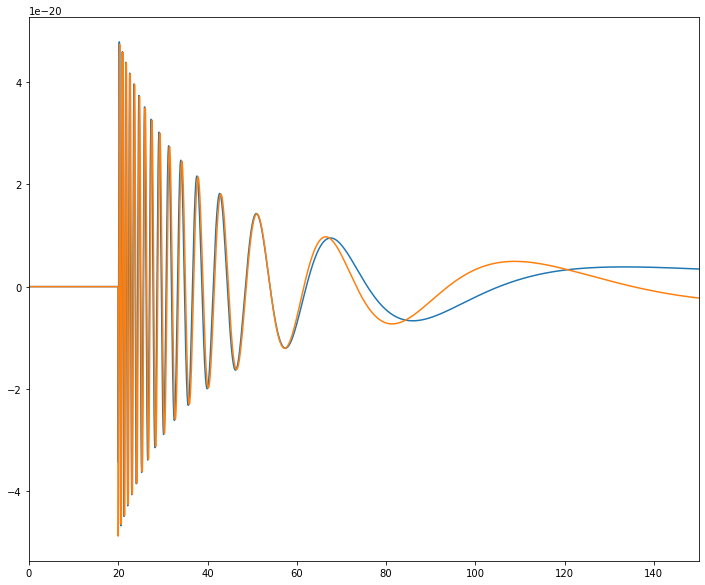

In [18]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
plt.plot(freq_range, np.real(hlm_xas[:-1]))
plt.plot(freq_range, np.real(hlm_d[:-1]))
plt.xlim (0, 150)

plt.show()

In [19]:
lam = 0.0

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lam)

match = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
print(f"Match to IMRPhenomXAS for lambda={lam} : {match:.3f}")


Match to IMRPhenomXAS for lambda=0.0 : 1.000


In [20]:
start = time.time()
lam = 1.0

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lam)

match = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
print(f"Match to IMRPhenomXAS for lambda={lam} : {match:.3f}")

end = time.time()
print(f"Calculation completed in {end-start:.2f} s")


Match to IMRPhenomXAS for lambda=1.0 : 0.994
Calculation completed in 4.54 s


In [21]:
n_lams = 10

lams = np.linspace(0.0, 1.0, n_lams)
matches = np.zeros(n_lams)

for i in range(0, n_lams):
    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
    hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, lams[i])

    matches[i] = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
    

In [22]:
for i in range(0, n_lams):
    print(f"Match to IMRPhenomXAS for lambda={lams[i]:.1f} : {matches[i]:.5f}")

Match to IMRPhenomXAS for lambda=0.0 : 1.00000
Match to IMRPhenomXAS for lambda=0.1 : 0.99949
Match to IMRPhenomXAS for lambda=0.2 : 0.99846
Match to IMRPhenomXAS for lambda=0.3 : 0.99748
Match to IMRPhenomXAS for lambda=0.4 : 0.99710
Match to IMRPhenomXAS for lambda=0.6 : 0.99719
Match to IMRPhenomXAS for lambda=0.7 : 0.99715
Match to IMRPhenomXAS for lambda=0.8 : 0.99651
Match to IMRPhenomXAS for lambda=0.9 : 0.99552
Match to IMRPhenomXAS for lambda=1.0 : 0.99445


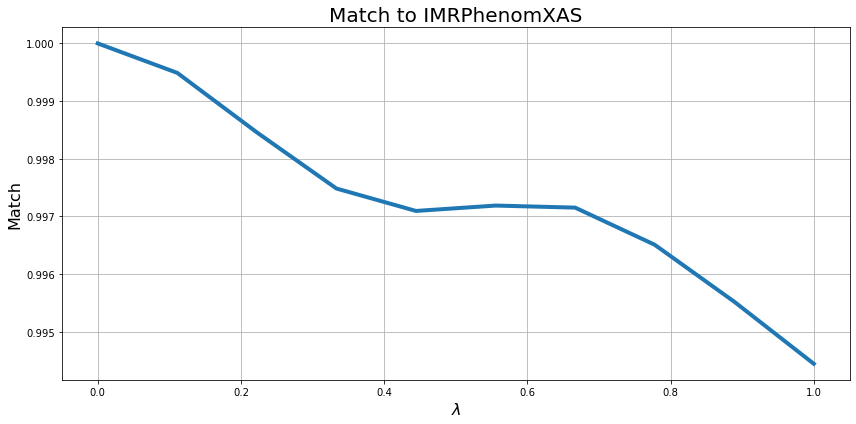

In [23]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(lams, matches, lw=lw)

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

## Limit to Monotonic Region

In [28]:
n_lams = 10

lams = np.linspace(0.0, 0.45, n_lams)
matches = np.zeros(n_lams)

for i in range(0, n_lams):
    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
    hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_1_LAL, hlm_2_LAL, lams[i])

    matches[i] = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
    

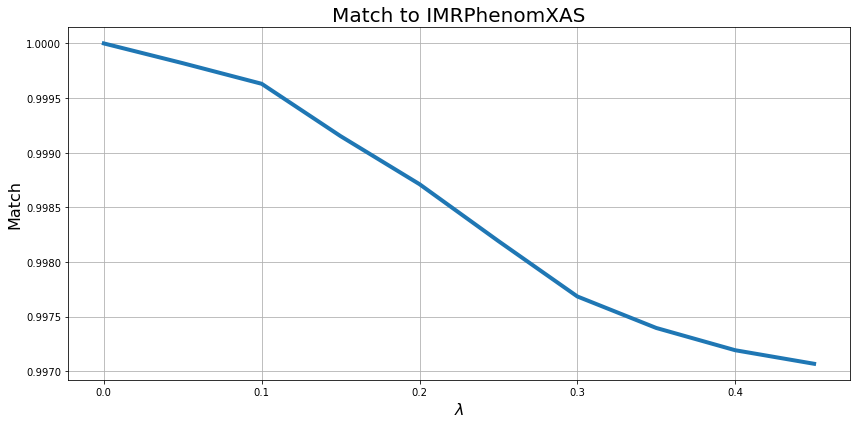

In [29]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(lams, matches, lw=lw)

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

# Faithfulness calc using new implementation 

In [55]:
def inner_prod(hlm1_FD, hlm2_FD, Sn):
    return 4*np.real(np.dot(np.conjugate(hlm1_FD),hlm2_FD/Sn.data.data))

In [56]:
def get_hyb_wf(hlm_1, hlm_2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
        
    a1 = np.abs(hlm_1)
    phi1 = np.unwrap(np.angle(hlm_1))   
    
    a2 = np.abs(hlm_2)
    phi2 = np.unwrap(np.angle(hlm_2))

    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    hlm_hyb =  a_hyb * np.exp(1.j * phi_hyb)
    
    return hlm_hyb

In [57]:
theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

In [58]:
def compute_faith_opt_opt(approx1, approx2, Sn, phi_opt_range, t_opt_range, lam, freq_range):
    faiths = np.zeros((len(phi_opt_range), len(t_opt_range)))

    hplus_1, hcross_1 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx1)
    h_1 = Fplus*hplus_1.data.data[:-1] + Fcross*hcross_1.data.data[:-1]

    for i, phi_opt in enumerate(phi_opt_range):
        # Generate second wavefunction with a phase shift (phi_opt)
        hplus_2, hcross_2 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef+phi_opt, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx2)
        h_2 = Fplus*hplus_2.data.data[:-1] + Fcross*hcross_2.data.data[:-1]
        h_2 = -h_2 

        h_hyb = get_hyb_wf(h_1, h_2, lam)

        # Implement time shift
        for j, t_opt in enumerate(t_opt_range):
            h_hyb_TD_shift = np.fft.fft(h_hyb * np.exp(-2*np.pi*1j*freq_range*t_opt))
            h_hyb_FD_shift = np.fft.ifft(h_hyb_TD_shift)

            faiths[i,j] = inner_prod(h_1, h_hyb_FD_shift, Sn) / (np.sqrt(inner_prod(h_1, h_1, Sn)) * np.sqrt(inner_prod(h_hyb_FD_shift, h_hyb_FD_shift, Sn)))

        # print(faiths[i])  
    return np.max(faiths)

In [61]:
approx1 = ls.IMRPhenomXAS
approx2 = ls.IMRPhenomD

N = 10
lams = np.linspace(0.0, 1.0, N)
faiths_opt_opt = np.zeros(N)

phi_opt_range = np.linspace(0, np.pi, 20)
t_opt_range = np.linspace(0, 0.1/f_low, 20)

for i in range(N):
    faiths_opt_opt[i] = compute_faith_opt_opt(approx1, approx2, Sn, phi_opt_range, t_opt_range, lams[i], freq_range) 


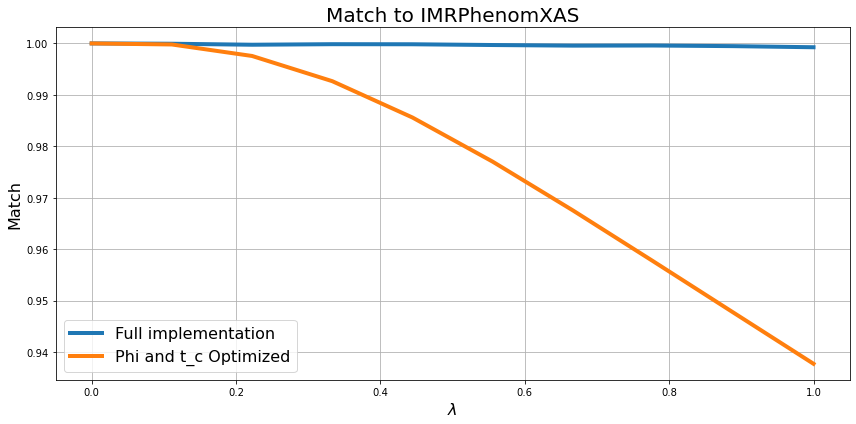

In [60]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4

plt.plot(lams, matches, lw=lw, label='Full implementation')

plt.plot(lams, faiths_opt_opt, lw=lw, label='Phi and t_c Optimized')

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)
# plt.ylim(0.92, 1)
plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()